In [1]:
from tools import *

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151507, size: (4226, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.2712691249918556


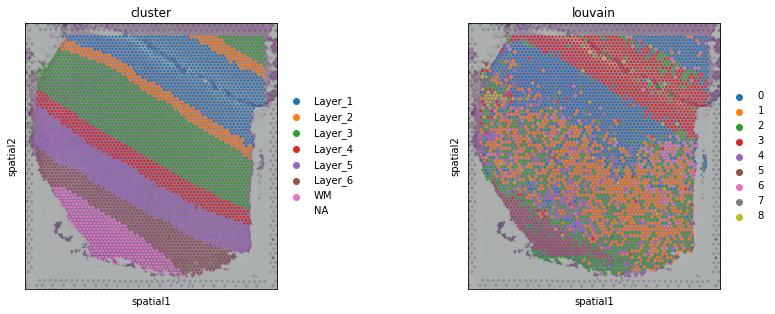

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151508, size: (4384, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.2681465839032741


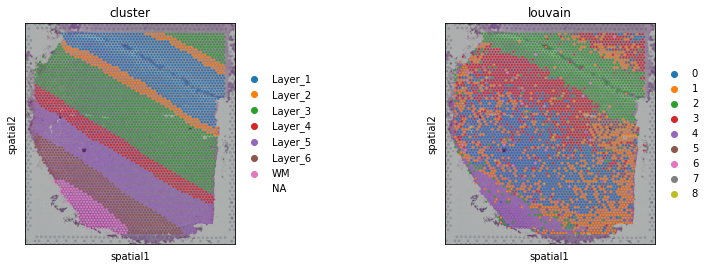

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151509, size: (4789, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.2759266126280806


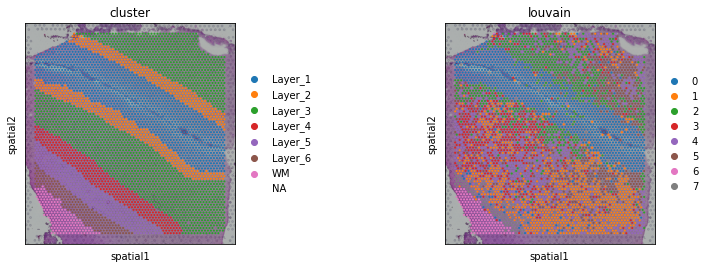

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151510, size: (4634, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.2781372404366445


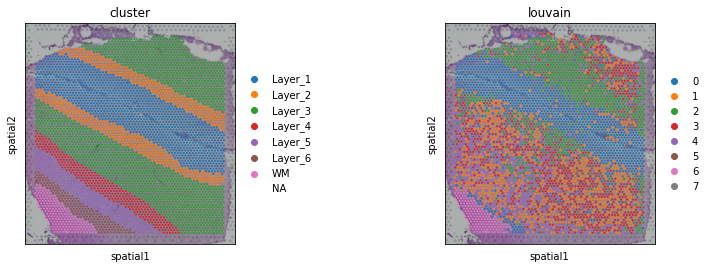

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151669, size: (3661, 33538), cluster: 5.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.11207827443366997


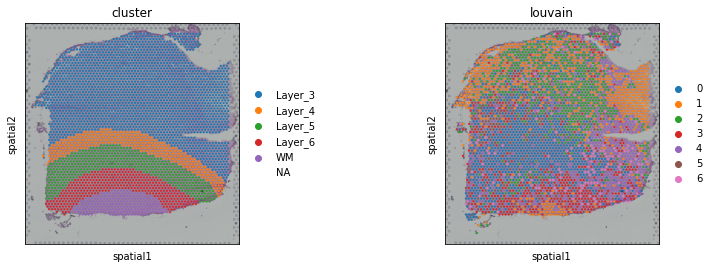

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151670, size: (3498, 33538), cluster: 5.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.050941746821400985


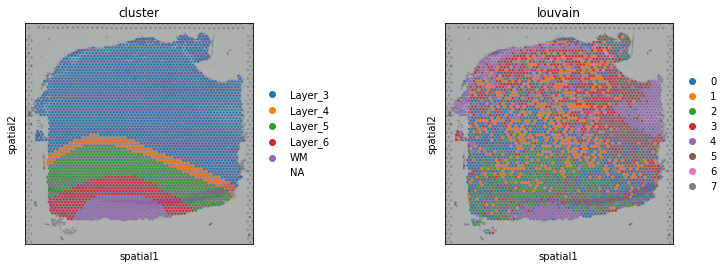

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151671, size: (4110, 33538), cluster: 5.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.25500307724507143


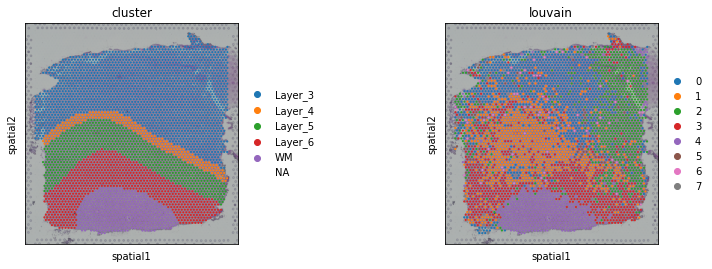

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151672, size: (4015, 33538), cluster: 5.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.23271276325868723


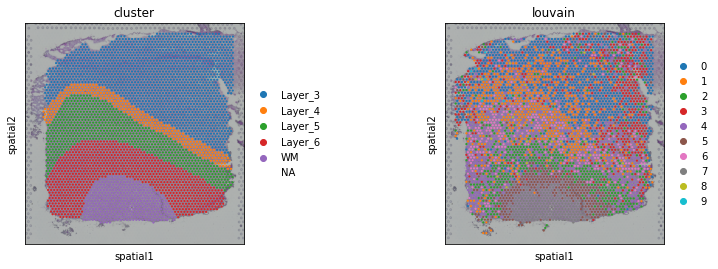

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151673, size: (3639, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.21699611516923742


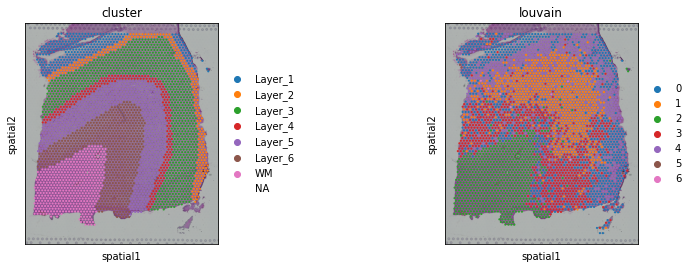

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151674, size: (3673, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.2715222514426986


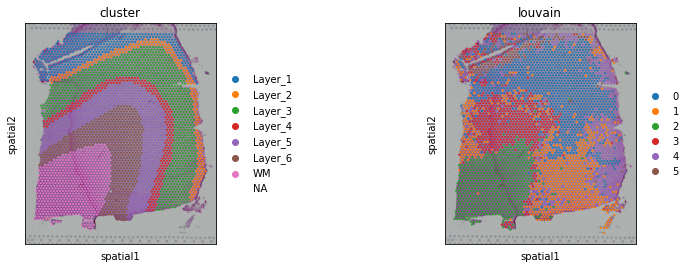

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151675, size: (3592, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.285600380621954


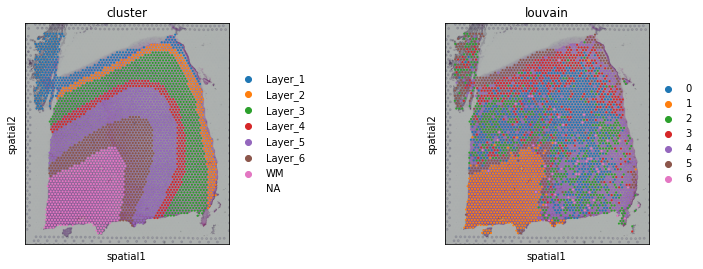

/home/shuhan/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> dataset id: 151676, size: (3460, 33538), cluster: 7.


/home/shuhan/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.
pred: 0.22743707157089288


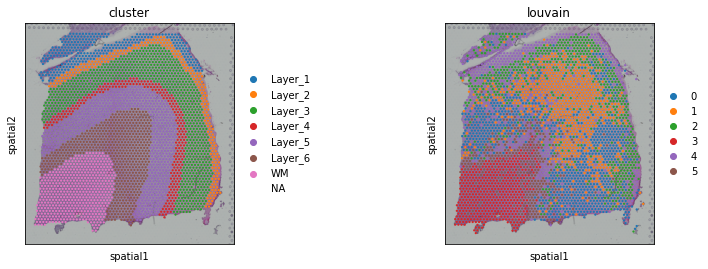

In [2]:
for i in range(12):
    adata, n_cluster = get_dlpfc_data(i)
    train(adata, 6)
    evaluate(adata)

## 测试如果不适用features生成图

In [6]:
# 建立一个独热编码的特征矩阵
one_hot = np.zeros((4226, 33538))
one_hot += np.eye(4226, 33538)
one_hot_adata = adata.copy()
one_hot_adata.X = one_hot
one_hot_adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster', 'louvain', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Cluster_colors', 'louvain_colors', 'leiden_colors'
    obsm: 'spatial'

         Falling back to preprocessing with `sc.pp.pca` and default params.


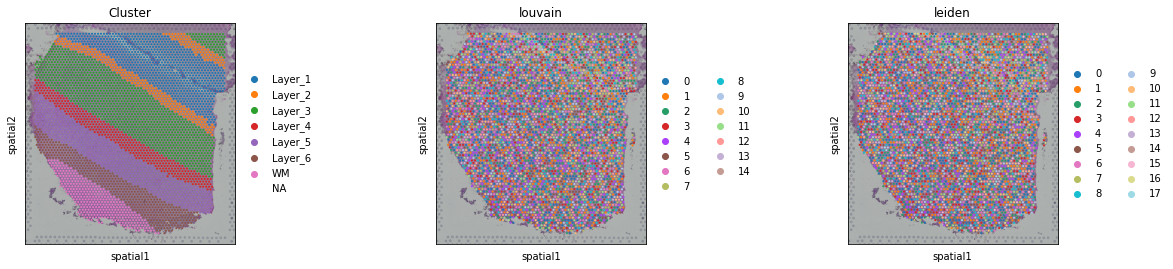

In [7]:
sc.pp.neighbors(one_hot_adata)
sc.tl.louvain(one_hot_adata)
sc.tl.leiden(one_hot_adata)
sc.pl.spatial(one_hot_adata, color=['Cluster', 'louvain', 'leiden'])